In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

cyto_path = f"/content/drive/My Drive/Bioinformatics/cyto.fasta.txt" 
secreted_path = f"/content/drive/My Drive/Bioinformatics/secreted.fasta.txt"
mito_path = f"/content/drive/My Drive/Bioinformatics/mito.fasta.txt"
nucleus_path = f"/content/drive/My Drive/Bioinformatics/nucleus.fasta.txt"
other_path = f"/content/drive/My Drive/Bioinformatics/other.fasta.txt"

Mounted at /content/drive


 # Preprocessing
 

In [ ]:
# Function to read FASTA file

def read_fasta(fp):
        name, seq = None, []
        for line in fp:
            line = line.rstrip()
            if line.startswith(">"):
                if name: yield (name, ''.join(seq))
                name, seq = line, []
            else:
                seq.append(line)
        if name: yield (name, ''.join(seq))

In [ ]:
# Filepath to sequences

# cyto_path = '/Users/udi/Desktop/DSML MSc/Term 2/COMP0082 Bioinformatics/CW/cyto.fasta.txt' 
# secreted_path = '/Users/udi/Desktop/DSML MSc/Term 2/COMP0082 Bioinformatics/CW/secreted.fasta.txt'
# mito_path = '/Users/udi/Desktop/DSML MSc/Term 2/COMP0082 Bioinformatics/CW/mito.fasta.txt'
# nucleus_path = '/Users/udi/Desktop/DSML MSc/Term 2/COMP0082 Bioinformatics/CW/nucleus.fasta.txt'
# other_path = '/Users/udi/Desktop/DSML MSc/Term 2/COMP0082 Bioinformatics/CW/other.fasta.txt'

locations = [cyto_path, secreted_path, mito_path, nucleus_path, other_path]

In [ ]:
# Reading sequences to dictionary

seq_dict = {}           

for location in locations:
    with open(location) as fp:
        seq_dict['%s' % location] = []
        for name, seq in read_fasta(fp):
            seq = " ".join(seq)
            seq_dict['%s' % location].append(seq)         

In [ ]:
# Converting dictionary to lists

seq_list = list(seq_dict.values())

cyto = seq_list[0]
secreted = seq_list[1]
mito = seq_list[2]
nucleus = seq_list[3]
other = seq_list[4]

# Creating labels, denoted by numbers, as recorded in the dictionary

labels ={'cyto':0, 'secreted': 1, 'mito': 2, 'nucleus': 3, 'other': 4}

cyto_label = [0] * len(cyto)
secreted_label = [1] * len(secreted)
mito_label = [2] * len(mito)
nucleus_label = [3] * len(nucleus)
other_label = [4] * len(other)

In [ ]:
# Longest and Shortest sequences

longest_seq = 0

for i in range(len(seq_list)):
    if len(max(seq_list[i], key=len)) > longest_seq:
        longest_seq = len(max(seq_list[i], key=len))



shortest_seq = 0

for i in range(len(seq_list)):
    if len(min(seq_list[i], key=len)) > shortest_seq:
        shortest_seq = len(min(seq_list[i], key=len))

# Need to halve as includes spaces. Also add 1 as last sequence didnt get space character
longest_seq = (longest_seq + 1)/2
shortest_seq = (shortest_seq + 1)/2

print('Longest sequence is: ', longest_seq)
print('Shortest sequence is: ', shortest_seq)

Longest sequence is:  13100.0
Shortest sequence is:  249.0


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


(200.0, 13500.0)

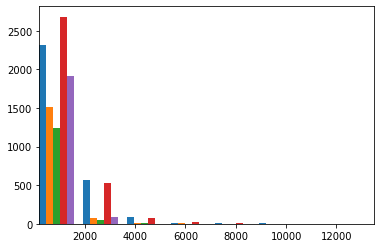

In [ ]:
import matplotlib.pyplot as plt 

plt.hist([[float(len(x)) for x in y] for y in seq_list], bins=15)
plt.xlim(200,13500)

 Most sequences seem to be at a length smaller than 2000.

# Creating training/validation/test sets

In [ ]:
# First we will put all the sequences into one list

all_seq = cyto + secreted + mito  + nucleus + other 
all_labels = cyto_label + secreted_label + mito_label  + nucleus_label + other_label

print('Both lists match:', len(all_seq) == len(all_labels), '. Total datapoints:', len(all_labels))

Both lists match: True . Total datapoints: 11224


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

# Set 10% for test set
seq_train, seq_test, labels_train, labels_test = train_test_split(all_seq, all_labels, test_size=0.1, random_state=42)

# 80% for training set, 10% for validation set
seq_train, seq_val, labels_train, labels_val = train_test_split(seq_train, labels_train, test_size=0.111, random_state=42)

In [ ]:
print('Training Set size:',len(seq_train), 
      '\nValidation Set size:', len(seq_val), 
      '\nTest Set size:', len(seq_test))


Training Set size: 8979 
Validation Set size: 1122 
Test Set size: 1123


There is a class imbalance in our dataset. So, we will first compute class weights for the labels in the train set and then pass these weights to the loss function so that it takes care of the class imbalance.

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_weights = compute_class_weight('balanced', np.unique(labels_train), labels_train)

print("Class Weights:",class_weights)

Class Weights: [0.74576412 1.38993808 1.76751969 0.67157816 1.13014475]


# Setting up the data

Here, we import our model and tokenizer

In [ ]:
!pip install transformers

from transformers import AutoTokenizer, AutoModelForMaskedLM  
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

tokenizer = AutoTokenizer.from_pretrained("Rostlab/prot_bert_bfd", do_lower_case=False)  

# model = AutoModelForSequenceClassification.from_pretrained("Rostlab/prot_bert_bfd")


     |████████████████████████████████| 1.9MB 5.8MB/s 
     |████████████████████████████████| 3.2MB 43.2MB/s 
     |████████████████████████████████| 890kB 34.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=488695fd142ff1b520175c44dad6684660cf4446f19f6171bc12487fb5a50f78
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
train_encodings = tokenizer(seq_train, truncation=True, padding=True, max_length=1024, return_tensors="pt")
val_encodings = tokenizer(seq_val, truncation=True, padding=True, max_length=1024, return_tensors="pt")
test_encodings = tokenizer(seq_test, truncation=True, padding=True, max_length=1024, return_tensors="pt")


In [ ]:
# Print the original sentence.
print(' Original: ', seq_train[3], '\nLength:', len(seq_train[3]))

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(seq_train[3]), '\nLength:', len(tokenizer.tokenize(seq_train[3])))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(seq_train[3])))

 Original:  M A A H L L P I C A L F L T L L D M A Q G F R G P L L P N R P F T T V W N A N T Q W C L E R H G V D V D V S V F D V V A N P G Q T F R G P D M T I F Y S S Q L G T Y P Y Y T P T G E P V F G G L P Q N A S L I A H L A R T F Q D I L A A I P A P D F S G L A V I D W E A W R P R W A F N W D T K D I Y R Q R S R A L V Q A Q H P D W P A P Q V E A V A Q D Q F Q G A A R A W M A G T L Q L G R A L R P R G L W G F Y G F P D C Y N Y D F L S P N Y T G Q C P S G I R A Q N D Q L G W L W G Q S R A L Y P S I Y M P A V L E G T G K S Q M Y V Q H R V A E A F R V A V A A G D P N L P V L P Y V Q I F Y D T T N H F L P L D E L E H S L G E S A A Q G A A G V V L W V S W E N T R T K E S C Q A I K E Y M D T T L G P F I L N V T S G A L L C S Q A L C S G H G R C V R R T S H P K A L L L L N P A S F S I Q L T P G G G P L S L R G A L S L E D Q A Q M A V E F K C R C Y P G W Q A P W C E R K S M W 
Length: 869
Tokenized:  ['M', 'A', 'A', 'H', 'L', 'L', 'P', 'I', 'C', 'A', 'L', 'F', 'L', 'T', 'L', 'L', 'D', 'M', 'A

Now, let’s turn our labels and encodings into a Dataset object. In PyTorch, this is done by subclassing a torch.utils.data.Dataset object and implementing __len__ and __getitem__.  

We put the data in this format so that the data can be easily batched such that each key in the batch encoding corresponds to a named parameter of the forward() method of the model we will train.

In [ ]:

import torch 

class SequenceDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
        
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['label'] = torch.tensor(self.labels[idx])
        return item
    
    def __len__(self):
        return len(self.labels)
    
train_dataset = SequenceDataset(train_encodings, labels_train)
val_dataset = SequenceDataset(val_encodings, labels_val)
test_dataset = SequenceDataset(test_encodings, labels_test)

In [ ]:

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=1,   # batch size per device during training
    per_device_eval_batch_size=32,   # batch size for evaluation
    warmup_steps=1000,               # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    #learning_rate=5e-5,              # initial learning rate for AdamW optimizer.           
    load_best_model_at_end=True,     # load the best model when finished training (default metric is loss)
    do_train=True,                   # Perform training
    do_eval=True,                    # Perform evaluation
    #label_names = ['cyto', 'secreted', 'mito', 'nucleus', 'other'], # Names of corresponding labels
    logging_dir='./logs',            # directory for storing logs    
    logging_steps=10,
    gradient_accumulation_steps=64,  # total number of steps before back propagation
    fp16=True,                       # Use mixed precision
    fp16_opt_level="02",             # mixed precision mode
    evaluation_strategy="epoch",     # evaluate each `logging_steps`
)


# Metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }






In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("Rostlab/prot_bert_bfd", 
                                                           num_labels=5,
                                                           output_attentions = False, # Whether the model returns attentions weights.
                                                           output_hidden_states = False
                                                           )

Some weights of the model checkpoint at Rostlab/prot_bert_bfd were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

We will create a custom trainer that takes into account the different weights of the classes in the training set




In [ ]:
from torch.nn import CrossEntropyLoss

class MyTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)    
    
    def compute_loss(self, model, inputs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs[0]
        loss = CrossEntropyLoss(weight=class_weights)
        return loss(logits, labels)

#logits = model(**input_dict)
#loss = CrossEntropyLoss(weight=class_weights)

#output = loss(logits, labels)


In [ ]:
#for param in model.bert.parameters():
#    param.requires_grad = False

def model_init():
  return AutoModelForSequenceClassification.from_pretrained("Rostlab/prot_bert_bfd", 
                                                           num_labels=5,
                                                           output_attentions = False, # Whether the model returns attentions weights.
                                                           output_hidden_states = False
                                                           )


trainer = MyTrainer(
    #model=model,                         # the instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,             # evaluation dataset
    model_init=model_init,
    compute_metrics=compute_metrics,
)



Some weights of the model checkpoint at Rostlab/prot_bert_bfd were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

RuntimeError: ignored

We will also perform Hyperparameter search to get the best parameters

In [ ]:
!pip install optuna




def my_hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 5e-5, 5e-2, log=True),
        "num_train_epochs": trial.suggest_int("num_train_epochs", 1, 5),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [1, 2, 4]),
    }

trainer.hyperparameter_search(direction="maximize", hp_space=my_hp_space)

[I 2021-03-02 13:12:12,079] A new study created in memory with name: no-name-7ea745c7-7c5e-40b3-b9ca-eeab005e8f98


KeyboardInterrupt: ignored

# Cross-Validation Training

The training set is split into 5-Fold 

Use average metrics

In [ ]:



trainer.train()